In [1]:
# import libraries
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class NonLinearDataset(Dataset):
    def __init__(self, n_samples=1000):
        X1 = np.random.uniform(-5, 5, n_samples)
        X2 = np.random.uniform(-5, 5, n_samples)
        X3 = np.random.uniform(-5, 5, n_samples)

        y = (2 * np.sin(X1) + 0.5 * X2**2 + 0.3 * X3**3 +
             np.cos(X1 * X2) + np.random.normal(0, 0.2, n_samples))

        self.X = torch.tensor(np.column_stack((X1, X2, X3)), dtype=torch.float32)
        self.y = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [3]:
class Manual3LayerNN(torch.nn.Module):
    def __init__(self, input_dim=3, h1=64, h2=32, h3=16, output_dim=1):
        super().__init__()
        # manually defining weights and biases
        self.W1 = torch.nn.Parameter(torch.randn(input_dim, h1) * np.sqrt(2. / input_dim))
        self.b1 = torch.nn.Parameter(torch.zeros(h1))

        self.W2 = torch.nn.Parameter(torch.randn(h1, h2) * np.sqrt(2. / h1))
        self.b2 = torch.nn.Parameter(torch.zeros(h2))

        self.W3 = torch.nn.Parameter(torch.randn(h2, h3) * np.sqrt(2. / h2))
        self.b3 = torch.nn.Parameter(torch.zeros(h3))

        self.W4 = torch.nn.Parameter(torch.randn(h3, output_dim) * np.sqrt(2. / h3))
        self.b4 = torch.nn.Parameter(torch.zeros(output_dim))

    def relu(self, x):
        return torch.maximum(x, torch.tensor(0.0))

    def forward(self, x):
        x = self.relu(torch.einsum('ij,jk->ik', x, self.W1) + self.b1)
        x = self.relu(torch.einsum('ij,jk->ik', x, self.W2) + self.b2)
        x = self.relu(torch.einsum('ij,jk->ik', x, self.W3) + self.b3)
        out = torch.einsum('ij,jk->ik', x, self.W4) + self.b4
        return out

In [4]:
def train_manual_model():
    train_data = NonLinearDataset(1000)
    val_data = NonLinearDataset(200)

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=32)

    model = Manual3LayerNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)

    train_losses = []
    val_losses = []

    for epoch in range(1000):
        model.train()
        total_train_loss = 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch)
                val_loss = criterion(y_pred, y_batch)
                total_val_loss += val_loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        scheduler.step(avg_val_loss)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

    return model, train_losses, val_losses

In [5]:
def plot_manual_results(model, train_losses, val_losses):
    test_data = NonLinearDataset(200)
    fig = plt.figure(figsize=(20, 5))

    # plotting losses
    ax1 = fig.add_subplot(131)
    ax1.plot(train_losses, label='Train')
    ax1.plot(val_losses, label='Validation')
    ax1.set_yscale('log')
    ax1.set_title("Loss over Epochs")
    ax1.legend()

    # 4D scatter plot
    ax2 = fig.add_subplot(132, projection='3d')
    with torch.no_grad():
        y_pred = model(test_data.X)

    scatter = ax2.scatter(test_data.X[:, 0], test_data.X[:, 1], test_data.X[:, 2],
                          c=y_pred.numpy(), cmap='plasma')
    plt.colorbar(scatter, ax=ax2, label='Prediction')
    ax2.set_xlabel("X1")
    ax2.set_ylabel("X2")
    ax2.set_zlabel("X3")
    ax2.set_title("4D Scatter Plot")

    # actual vs predicted values
    ax3 = fig.add_subplot(133)
    ax3.scatter(test_data.y.numpy(), y_pred.numpy(), alpha=0.5)
    ax3.plot([test_data.y.min(), test_data.y.max()],
             [test_data.y.min(), test_data.y.max()], 'r--')
    ax3.set_xlabel("Actual")
    ax3.set_ylabel("Predicted")
    ax3.set_title("Actual vs Predicted")

    plt.tight_layout()
    plt.show()

Epoch 0: Train Loss = 170.2806, Val Loss = 151.2258
Epoch 100: Train Loss = 1.2278, Val Loss = 2.2484
Epoch 200: Train Loss = 0.5206, Val Loss = 1.3458
Epoch 300: Train Loss = 0.5410, Val Loss = 1.3415
Epoch 400: Train Loss = 0.5148, Val Loss = 1.3416
Epoch 500: Train Loss = 0.5188, Val Loss = 1.3417
Epoch 600: Train Loss = 0.5156, Val Loss = 1.3417
Epoch 700: Train Loss = 0.5228, Val Loss = 1.3418
Epoch 800: Train Loss = 0.5171, Val Loss = 1.3418
Epoch 900: Train Loss = 0.5122, Val Loss = 1.3418


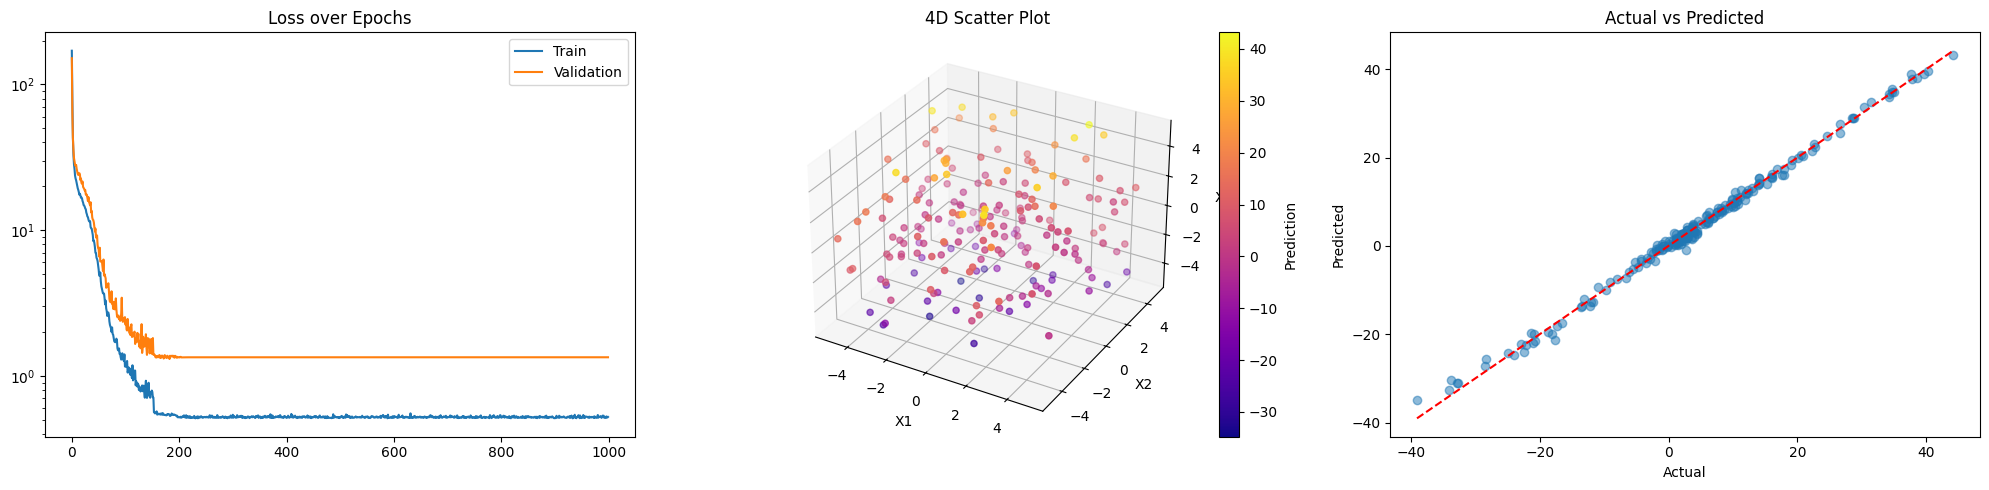

Input (x1, x2, x3)        |   Prediction |       Actual
-------------------------------------------------------
(  -4,   -4,   -4)       |      -10.268 |      -10.644
(  -2,   -2,   -2)       |       -2.293 |       -2.872
(   0,    0,    0)       |        0.269 |        1.000
(   2,    2,    2)       |        5.919 |        5.565
(   4,    4,    4)       |       26.589 |       24.729


In [6]:
def main():
    model, train_losses, val_losses = train_manual_model()
    plot_manual_results(model, train_losses, val_losses)

    # test the predictions
    test_points = [(-4, -4, -4), (-2, -2, -2), (0, 0, 0), (2, 2, 2), (4, 4, 4)]
    print(f"{'Input (x1, x2, x3)':<25} | {'Prediction':>12} | {'Actual':>12}")
    print("-" * 55)

    for x1, x2, x3 in test_points:
        x_tensor = torch.FloatTensor([[x1, x2, x3]])
        pred = model(x_tensor).item()
        actual = 2 * np.sin(x1) + 0.5 * x2**2 + 0.3 * x3**3 + np.cos(x1 * x2)
        print(f"({x1:>4}, {x2:>4}, {x3:>4})       | {pred:12.3f} | {actual:12.3f}")

main()